# 🧠 Next Word Prediction with LSTM

## 📑 Table of Contents

1. **Text Preprocessing and Tokenization**  
   Load a simple input sentence, convert it to lowercase, split it into tokens (words), and build the vocabulary. Map each unique word to a unique index.

2. **Sequence Generation**  
   Prepare training data by creating sequences of fixed length (e.g., 3 words) and use the next word as the label. This helps the model learn the next word prediction task.

3. **Embedding Layer Initialization**  
   Create a random embedding matrix to convert word indices into dense vector representations. Each word is mapped to a real-valued vector in a continuous space.

4. **LSTM Parameter Setup**  
   Initialize the weights and biases for all LSTM gates: forget gate, input gate, output gate, and candidate gate. Also initialize the weights for the output softmax layer.

5. **Forward Pass Function**  
   Manually implement the LSTM forward pass over a sequence of embedded vectors. At each step, update the hidden state and cell state using the gate equations.

6. **Training Loop**  
   Train the model by looping through all training sequences. Compute loss (cross-entropy), calculate the gradient for the output layer, and update weights using gradient descent.

7. **Next Word Prediction**  
   Use the trained model to predict the next word given a sequence of words. Feed the input through the LSTM and return the word with the highest predicted probability.


In [3]:
import numpy as np

### 1. Tokenization

In [14]:
text = "i went to school today and saw my friend"
text

'i went to school today and saw my friend'

In [15]:
tokens = text.lower().split()
tokens

['i', 'went', 'to', 'school', 'today', 'and', 'saw', 'my', 'friend']

In [27]:
len(tokens)

9

In [16]:
vocab = sorted(set(tokens))
vocab

['and', 'friend', 'i', 'my', 'saw', 'school', 'to', 'today', 'went']

In [17]:
word2idx = {w: i for i, w in enumerate(vocab)}
word2idx

{'and': 0,
 'friend': 1,
 'i': 2,
 'my': 3,
 'saw': 4,
 'school': 5,
 'to': 6,
 'today': 7,
 'went': 8}

In [18]:
idx2word = {i: w for w, i in word2idx.items()}
idx2word

{0: 'and',
 1: 'friend',
 2: 'i',
 3: 'my',
 4: 'saw',
 5: 'school',
 6: 'to',
 7: 'today',
 8: 'went'}

In [19]:
vocab_size = len(vocab)
vocab_size

9

In [20]:
encoded = [word2idx[w] for w in tokens]
encoded

[2, 8, 6, 5, 7, 0, 4, 3, 1]

In [25]:
for token in tokens:
    print(f"{token} -> {word2idx[token]}")

i -> 2
went -> 8
to -> 6
school -> 5
today -> 7
and -> 0
saw -> 4
my -> 3
friend -> 1


### 2. Create sequences

In [26]:
len(encoded)

9

In [35]:
seq_len = 3
X, y = [], []

for i in range(len(encoded) - seq_len):
    x_seq = encoded[i:i+seq_len]
    y_val = encoded[i+seq_len]

    x_words = [idx2word[idx] for idx in x_seq]
    y_word = idx2word[y_val]

    print(f"idx {i}: X = {x_seq} → {x_words} | y = {y_val} → '{y_word}'")

    X.append(x_seq)
    y.append(y_val)

idx 0: X = [2, 8, 6] → ['i', 'went', 'to'] | y = 5 → 'school'
idx 1: X = [8, 6, 5] → ['went', 'to', 'school'] | y = 7 → 'today'
idx 2: X = [6, 5, 7] → ['to', 'school', 'today'] | y = 0 → 'and'
idx 3: X = [5, 7, 0] → ['school', 'today', 'and'] | y = 4 → 'saw'
idx 4: X = [7, 0, 4] → ['today', 'and', 'saw'] | y = 3 → 'my'
idx 5: X = [0, 4, 3] → ['and', 'saw', 'my'] | y = 1 → 'friend'


In [32]:
X, y = np.array(X), np.array(y)

In [33]:
X

array([[2, 8, 6],
       [8, 6, 5],
       [6, 5, 7],
       [5, 7, 0],
       [7, 0, 4],
       [0, 4, 3]])

In [34]:
y

array([5, 7, 0, 4, 3, 1])

### 3. Embedding layer
#### Embedding Matrix = L × F (vocab_size x embedding_dim)

In [44]:
embedding_dim = 16
embedding_matrix = np.random.randn(vocab_size, embedding_dim)
print(embedding_matrix.shape)

(9, 16)


In [45]:
for L, F in zip(vocab, embedding_matrix):
    print(f"{L} -> {F}")
    print()

and -> [ 0.11543083 -0.07019845  0.08643759  0.65703081 -2.19138714  1.28409386
  0.84668077 -1.15482165 -0.73885418 -0.19651627 -0.39082077 -1.57551863
 -1.19445244 -0.22115299  0.52736895 -1.2280768 ]

friend -> [-0.05658094 -0.05614867  0.02867314 -0.37520037 -1.32539362 -0.78291934
 -0.80042999 -1.26078613 -0.75419314  0.50721373 -0.63621335  1.02623947
  0.21181235  0.21513954 -1.02896819 -1.74652134]

i -> [-1.66456541  0.09069771  2.16695487 -1.06235202  0.44916002 -1.21729866
  0.0824503  -1.1132736  -0.662327    1.0005726  -0.35634488 -1.27962238
  0.35946778  0.39672816  0.98535949  0.75163843]

my -> [-0.04156241 -1.01505888 -0.17321684 -1.46088203 -0.89892313  1.39302825
  0.30690955  0.77771847 -0.84501058  1.97537753  0.92366948 -2.70542157
  1.17324555  0.49630453  1.69114473 -1.41645867]

saw -> [-0.17233389 -0.37364647  0.48122805 -1.1093155   0.83896596 -1.6898772
 -1.15070181  1.21470681  0.66984805  0.72671698 -1.12632952  0.31942685
  0.67983218  0.38682828 -1.1273

In [46]:
def embed(seq):
    return np.array([embedding_matrix[i] for i in seq])

In [49]:
embed([2, 5, 3])

array([[-1.66456541,  0.09069771,  2.16695487, -1.06235202,  0.44916002,
        -1.21729866,  0.0824503 , -1.1132736 , -0.662327  ,  1.0005726 ,
        -0.35634488, -1.27962238,  0.35946778,  0.39672816,  0.98535949,
         0.75163843],
       [-0.51112366,  0.05429472, -0.62765702, -1.37233772,  1.11700682,
         0.0287883 ,  0.23300635,  0.80104503, -0.76022689,  1.01687338,
         0.96305667, -0.6501175 , -0.24747654,  0.40040409,  0.32578529,
        -0.46969748],
       [-0.04156241, -1.01505888, -0.17321684, -1.46088203, -0.89892313,
         1.39302825,  0.30690955,  0.77771847, -0.84501058,  1.97537753,
         0.92366948, -2.70542157,  1.17324555,  0.49630453,  1.69114473,
        -1.41645867]])


### 📘 What is LSTM and Why Do We Use It for Next Word Prediction?

LSTM, which stands for **Long Short-Term Memory**, is a special type of recurrent neural network (RNN) designed to handle **sequential data** — data where the **order of information matters**, like text or time series.

Traditional RNNs suffer from the **vanishing gradient problem**, which means they struggle to learn long-range dependencies in a sequence. LSTM overcomes this limitation by using a **memory cell and gating mechanisms** (forget gate, input gate, and output gate) that help it decide **what information to keep, update, or discard** over time.

In **Next Word Prediction**, the goal is to predict the most likely next word given a sequence of previous words. For example:

> "I went to the" → model should predict: `"store"` or `"school"`

This task requires the model to understand:

* The **context** of the previous words
* The **semantic meaning** of each word
* And the **order** in which words appear

LSTM is ideal for this task because:

* It can **remember relevant patterns** in word sequences
* It uses **contextual memory** to make better predictions
* It learns how to handle **language dependencies** like grammar, subject–verb agreement, etc.


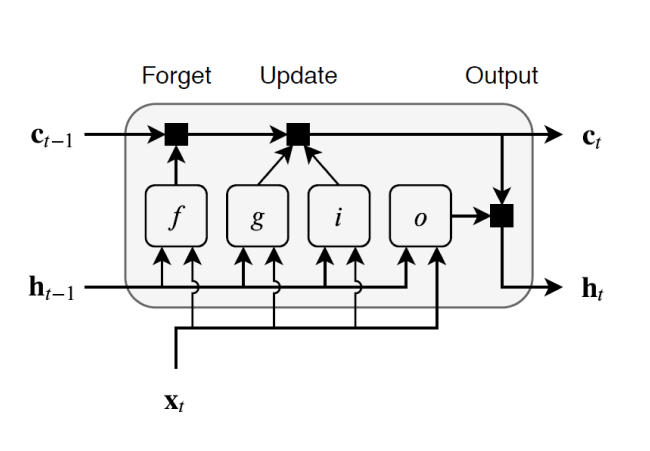

### 4. LSTM parameters




# 📘 Understanding LSTM Components

In this section, we break down the internal components of an LSTM and explain **how each part works step-by-step** using a real sentence example from our code.

---

## 🔹 Example Input Sequence

Let's consider this input sentence:

```

"I went to school today and saw my friend"

````

From this sentence, we extract the following training sequence (with `seq_len = 3`):

```python
X = ['i', 'went', 'to']
y = 'school'  # next word to predict
````

This sequence is converted to indices using `word2idx`, then passed to the embedding layer:

```
X_encoded = [2, 8, 6]
X_embedded = embed(X_encoded)  # shape = (3, embedding_dim)
```

---

## 🔧 LSTM Components (at each time step)

An LSTM processes this input **one token at a time**, maintaining internal states. For each token, it computes the following:

---

### 1. 🔗 Concatenation

Each input vector (`x_t`) is concatenated with the previous hidden state (`h_{t-1}`):

```
concat = [h_{t-1}; x_t]  # shape: (hidden_size + embedding_dim)
```

This is the base input for all LSTM gates.

---

### 2. 🔒 Forget Gate

```python
f_t = sigmoid(Wf @ concat + bf)
```

📌 Purpose:
Decides **how much of the previous cell state (`c_{t-1}`)** to keep or forget.

✅ Example:
If the current word is "went" and previous cell state includes "i", the model may choose to keep the subject context if it's still relevant.

---

### 3. 🧠 Input Gate

```python
i_t = sigmoid(Wi @ concat + bi)
c_hat_t = tanh(Wc @ concat + bc)
```

📌 Purpose:
Determines how much **new information** to write into the current memory.

✅ Example:
For "to", the model learns that it's part of the "i went to" structure and should influence memory update.

---

### 4. 💾 Cell State Update

```python
c_t = f_t * c_{t-1} + i_t * c_hat_t
```

📌 Purpose:
Updates the **internal memory (`c_t`)**, combining retained old memory and new content.

---

### 5. 🚪 Output Gate and Hidden State

```python
o_t = sigmoid(Wo @ concat + bo)
h_t = o_t * tanh(c_t)
```

📌 Purpose:

* Computes the **hidden state (`h_t`)**, which is used for:

  * Passing to the next time step
  * Generating output prediction

✅ Example:
After processing "i", "went", and "to", `h_t` encodes their joint meaning — e.g., movement or action — and is ready to predict "school".

---

### 6. 🎯 Final Prediction (Softmax Output)

```python
y_hat = softmax(Wy @ h_t + by)
```

📌 Purpose:
Gives a **probability distribution over the entire vocabulary**, predicting the most likely next word.

✅ In our example:
The model assigns high probability to `"school"` given the context `"i went to"`.

---

## ✅ Summary of LSTM Internals

| Component  | Role in LSTM                                                        |
| ---------- | ------------------------------------------------------------------- |
| `Wf`, `bf` | Forget gate: What to discard from memory                            |
| `Wi`, `bi` | Input gate: What new info to add to memory                          |
| `Wc`, `bc` | Candidate memory: The new memory proposal                           |
| `Wo`, `bo` | Output gate: What part of memory to pass to the output              |
| `Wy`, `by` | Final output layer: Predict the next word                           |
| `c_t`      | Cell state: Internal memory of the model                            |
| `h_t`      | Hidden state: Encoded summary of input so far (used for prediction) |

---

Using these mechanisms, LSTM learns **how language flows**, remembers important tokens, and discards irrelevant ones — enabling accurate next-word predictions even in complex sentences.
```

In [7]:
hidden_size = 32
concat_size = embedding_dim + hidden_size

Wf = np.random.randn(hidden_size, concat_size) * 0.1
Wi = np.random.randn(hidden_size, concat_size) * 0.1
Wo = np.random.randn(hidden_size, concat_size) * 0.1
Wc = np.random.randn(hidden_size, concat_size) * 0.1
bf = np.zeros((hidden_size, 1))
bi = np.zeros((hidden_size, 1))
bo = np.zeros((hidden_size, 1))
bc = np.zeros((hidden_size, 1))

Wy = np.random.randn(vocab_size, hidden_size) * 0.1
by = np.zeros((vocab_size, 1))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    e = np.exp(x - np.max(x))
    return e / np.sum(e)

### 5. LSTM forward

In [8]:
def forward(x_embedded):
    h = np.zeros((hidden_size, 1))
    c = np.zeros((hidden_size, 1))
    for xt in x_embedded:
        xt = xt.reshape(-1, 1)
        concat = np.vstack((h, xt))
        f = sigmoid(Wf @ concat + bf)
        i = sigmoid(Wi @ concat + bi)
        o = sigmoid(Wo @ concat + bo)
        c_hat = np.tanh(Wc @ concat + bc)
        c = f * c + i * c_hat
        h = o * np.tanh(c)
    y = Wy @ h + by
    return softmax(y), h, c


### 6. Training loop

In [9]:

lr = 0.01
epochs = 10000

for epoch in range(epochs):
    total_loss = 0
    for i in range(len(X)):
        x_seq = embed(X[i])
        target = y[i]
        pred, h_final, c_final = forward(x_seq)
        loss = -np.log(pred[target])
        total_loss += loss

        # Gradient for output layer only
        dy = pred.copy()
        dy[target] -= 1
        Wy -= lr * dy @ h_final.T
        by -= lr * dy

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss[0]:.4f}")

Epoch 0, Loss: 13.2432
Epoch 100, Loss: 11.0453
Epoch 200, Loss: 9.7431
Epoch 300, Loss: 8.7554
Epoch 400, Loss: 7.9385
Epoch 500, Loss: 7.2390
Epoch 600, Loss: 6.6302
Epoch 700, Loss: 6.0956
Epoch 800, Loss: 5.6234
Epoch 900, Loss: 5.2046
Epoch 1000, Loss: 4.8319
Epoch 1100, Loss: 4.4989
Epoch 1200, Loss: 4.2007
Epoch 1300, Loss: 3.9328
Epoch 1400, Loss: 3.6914
Epoch 1500, Loss: 3.4733
Epoch 1600, Loss: 3.2756
Epoch 1700, Loss: 3.0960
Epoch 1800, Loss: 2.9323
Epoch 1900, Loss: 2.7828
Epoch 2000, Loss: 2.6458
Epoch 2100, Loss: 2.5201
Epoch 2200, Loss: 2.4043
Epoch 2300, Loss: 2.2975
Epoch 2400, Loss: 2.1988
Epoch 2500, Loss: 2.1073
Epoch 2600, Loss: 2.0223
Epoch 2700, Loss: 1.9433
Epoch 2800, Loss: 1.8696
Epoch 2900, Loss: 1.8008
Epoch 3000, Loss: 1.7364
Epoch 3100, Loss: 1.6761
Epoch 3200, Loss: 1.6195
Epoch 3300, Loss: 1.5663
Epoch 3400, Loss: 1.5161
Epoch 3500, Loss: 1.4689
Epoch 3600, Loss: 1.4243
Epoch 3700, Loss: 1.3821
Epoch 3800, Loss: 1.3422
Epoch 3900, Loss: 1.3043
Epoch 4000

### 7. Predict next word

In [11]:
def predict(seed_text):
    seed_tokens = seed_text.lower().split()[-seq_len:]
    x_seq = [word2idx[w] for w in seed_tokens]
    x_embedded = embed(x_seq)
    pred, _, _ = forward(x_embedded)
    return idx2word[np.argmax(pred)]


In [12]:
print("Next word after 'i went to':", predict("i went to"))
print("Next word after 'went to school':", predict("went to school"))
print("Next word after 'to school today':", predict("to school today"))
print("Next word after 'school today and':", predict("school today and"))
print("Next word after 'today and saw':", predict("today and saw"))
print("Next word after 'and saw my':", predict("and saw my"))

Next word after 'i went to': school
Next word after 'went to school': today
Next word after 'to school today': and
Next word after 'school today and': saw
Next word after 'today and saw': my
Next word after 'and saw my': friend
